# Bus Simulator Sandbox (under development)
## Yuwen Chang

In [1]:
# import packages
from __future__ import print_function, division

import os
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import calendar
from datetime import datetime

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Yuwen/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [83]:
# import geopandas as gpd
# import fiona
# import shapely

# I. Data Generation Pipeline
## 1. Vehicle Data
## 1a. Real-time Data Query
# This section has been moved to sandbox_bus_data.ipynb

## 1b. Historical Sample Data

Currently referring to [data provided by MTA](http://web.mta.info/developers/MTA-Bus-Time-historical-data.html).

## 2. Route Data
### Issue: data query improvement
1. Upload data to Carto, and make queries with SQL
2. Directly query data from server

In [7]:
shapes = pd.read_csv("https://transitfeeds-data.s3-us-west-1.amazonaws.com/public/feeds/mta/80/20171221/original/shapes.txt")
shapes.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,B10163,40.621899,-74.028521,10001
1,B10163,40.621996,-74.028681,10002
2,B10163,40.622084,-74.028641,10003
3,B10163,40.622790,-74.028353,10004
4,B10163,40.622721,-74.028256,10005


In [8]:
stops = pd.read_csv("https://transitfeeds-data.s3-us-west-1.amazonaws.com/public/feeds/mta/80/20170823/original/stops.txt")
stops.head()

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,300000,ORIENTAL BL/MACKENZIE ST,NaN,40.578252,-73.939743,NaN,NaN,0,NaN
1,300002,ORIENTAL BL/JAFFRAY ST,NaN,40.578066,-73.943029,NaN,NaN,0,NaN
2,300003,ORIENTAL BL/HASTINGS ST,NaN,40.577962,-73.944662,NaN,NaN,0,NaN
3,300004,ORIENTAL BL/FALMOUTH ST,NaN,40.577719,-73.946208,NaN,NaN,0,NaN
4,300006,ORIENTAL BL/DOVER ST,NaN,40.577353,-73.949552,NaN,NaN,0,NaN


In [9]:
trips = pd.read_csv("https://transitfeeds-data.s3-us-west-1.amazonaws.com/public/feeds/mta/80/20170823/original/trips.txt")
trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,Q24,EN_O7-Weekday,EN_O7-Weekday-007000_Q24_401,JAMAICA 168 ST via ATLANTIC,0,Q240084
1,Q56,EN_O7-Weekday,EN_O7-Weekday-012000_Q24_401,BWAY JCT VN SNDRN AV,1,Q560039
2,Q56,EN_O7-Weekday,EN_O7-Weekday-016000_Q24_401,JAMAICA 170 ST,0,Q560038
3,Q24,EN_O7-Weekday,EN_O7-Weekday-020000_Q24_401,LFYTT ST PTCHN AV via ATLNTC AV via BDWY,1,Q240080
4,Q24,EN_O7-Weekday,EN_O7-Weekday-024500_Q24_401,JAMAICA 168 ST via ATLANTIC,0,Q240084


In [10]:
sched = pd.read_csv("https://transitfeeds-data.s3-us-west-1.amazonaws.com/public/feeds/mta/80/20170823/original/stop_times.txt")
sched.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,EN_O7-Weekday-007000_Q24_401,01:10:00,01:10:00,302058,1,0,0
1,EN_O7-Weekday-007000_Q24_401,01:10:19,01:10:19,307228,2,0,0
2,EN_O7-Weekday-007000_Q24_401,01:11:10,01:11:10,302059,3,0,0
3,EN_O7-Weekday-007000_Q24_401,01:12:04,01:12:04,307154,4,0,0
4,EN_O7-Weekday-007000_Q24_401,01:13:24,01:13:24,307155,5,0,0


### Issue: process automation

In [11]:
# select shape_id by the most frequent one
rt_shp = trips[(trips['route_id'] == bus) & (trips['direction_id'] == direction)]['shape_id'].value_counts(sort=True, ascending=False).index[0]
rt_shp

'B540062'

In [12]:
# extract points consisting the route shape
temp_shp = shapes[shapes['shape_id'] == rt_shp].drop_duplicates(subset=['shape_pt_lat', 'shape_pt_lon'])

In [13]:
# subset the stop_id belonging to the route
temp_B54 = sched[(sched['trip_id'] == "FP_D7-Weekday-SDon-062200_B54_207")]
temp_B54['stop_id'].values

array([308472, 307493, 308638, 306932, 306931, 306930, 306929, 306927,
       304390, 304391, 304392, 304393, 304394, 304396, 308442, 304398,
       304399, 304400, 304401, 304402, 307125, 304404, 304405, 304406,
       304407, 304408, 304409, 304410, 304411, 304412, 304413, 308596,
       901258])

In [14]:
# extract stop locations
B54_stops = stops[[(s in temp_B54['stop_id'].values) for s in stops['stop_id']]]
B54_stops

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
2228,304390,MYRTLE AV/CLINTON AV,NaN,40.693104,-73.968360,NaN,NaN,0,NaN
2229,304391,MYRTLE AV/WASHINGTON AV,NaN,40.693329,-73.966463,NaN,NaN,0,NaN
2230,304392,MYRTLE AV/RYERSON ST,NaN,40.693542,-73.964581,NaN,NaN,0,NaN
2231,304393,MYRTLE AV/STEUBEN ST,NaN,40.693756,-73.962745,NaN,NaN,0,NaN
2232,304394,MYRTLE AV/CLASSON AV,NaN,40.693991,-73.960664,NaN,NaN,0,NaN
2233,304396,MYRTLE AV/FRANKLIN AV,NaN,40.694347,-73.957595,NaN,NaN,0,NaN
2234,304398,MYRTLE AV/WALWORTH ST,NaN,40.694776,-73.953848,NaN,NaN,0,NaN
2235,304399,MYRTLE AV/NOSTRAND AV,NaN,40.694977,-73.952532,NaN,NaN,0,NaN
2236,304400,MYRTLE AV/MARCY AV,NaN,40.695293,-73.949344,NaN,NaN,0,NaN
2237,304401,MYRTLE AV/TOMPKINS AV,NaN,40.695624,-73.946502,NaN,NaN,0,NaN


In [45]:
# merge to the schedule dataframe so the stops are ordered along the route
temp_B54_2 = pd.DataFrame({'stop_id':temp_B54['stop_id'].values})
B54_merge = temp_B54_2.merge(B54_stops, on='stop_id', how='left')
B54_merge.head()

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,308472,JAY ST/MYRTLE PLZ,NaN,40.694503,-73.987123,NaN,NaN,0,NaN
1,307493,TILLARY ST/JAY ST,NaN,40.695957,-73.986776,NaN,NaN,0,NaN
2,308638,MYRTLE AV/FLEET PL,NaN,40.693465,-73.981502,NaN,NaN,0,NaN
3,306932,MYRTLE AV/ASHLAND PL,NaN,40.693431,-73.979334,NaN,NaN,0,NaN
4,306931,MYRTLE AV/ST EDWARDS ST,NaN,40.693356,-73.977372,NaN,NaN,0,NaN


## 3. Visualization
## 3a. Plain Line
### Issue: dynamic update controller

In [26]:
# import osmnx as ox
# import networkx as nx
# import geopandas as gpd
# from collections import Counter

# from geopy import Nominatim
from geopy.distance import vincenty
# from shapely.geometry import Point

### Issue: precision
1. Use distance along the route (geopy, Google API, or Carto API)
2. Preferably, find SIRI data that contains variable "CallDistanceAlongRoute"
3. Check visualization directions

In [46]:
# calculate stop distances
dist = []
lats = list(B54_merge['stop_lat'])
lons = list(B54_merge['stop_lon'])
for i in arange(len(B54_stops)):
    if i < len(B54_stops) - 1:
        p1 = lats[i], lons[i]
        p2 = lats[i+1], lons[i+1]
        di = vincenty(p1, p2).meters
        dist.append(di)
dist

[164.10592592573394,
 524.6821220855292,
 183.2864635647531,
 166.04481363027242,
 168.16662072005468,
 249.32389728515443,
 280.8678932398275,
 65.1613773786362,
 162.277246106055,
 160.8227222138864,
 156.99423276306914,
 177.8182272706027,
 262.3958689692586,
 186.7201549309188,
 134.44950499065496,
 113.44836241741916,
 271.7303956584878,
 243.00538513176005,
 292.5054493596941,
 190.84614888127206,
 295.74318979161654,
 180.16350288585392,
 297.9947729558094,
 205.45446314960742,
 168.5189134674809,
 151.1404164049675,
 170.5531370778554,
 218.34221496184352,
 226.21779839123397,
 226.0960471262775,
 374.39793393469455,
 130.71672370770722]

In [51]:
# calculate stop distances along the route (cumulative distance)
di = 0
cum_dist = [0]
for d in dist[:-1]:
    di += d
    cum_dist.append(di)
cum_dist = np.array(cum_dist)
cum_dist

array([   0.        ,  164.10592593,  688.78804801,  872.07451158,
       1038.11932521, 1206.28594593, 1455.60984321, 1736.47773645,
       1801.63911383, 1963.91635994, 2124.73908215, 2281.73331491,
       2459.55154218, 2721.94741115, 2908.66756608, 3043.11707107,
       3156.56543349, 3428.29582915, 3671.30121428, 3963.80666364,
       4154.65281252, 4450.39600231, 4630.5595052 , 4928.55427816,
       5134.00874131, 5302.52765477, 5453.66807118, 5624.22120826,
       5842.56342322, 6068.78122161, 6294.87726874, 6669.27520267])

In [57]:
df['VehDistAlongRoute']

1     269.72
2     269.72
3     269.72
4     269.72
5     269.72
6     269.72
7     269.72
8     269.72
9     269.72
10    269.72
Name: VehDistAlongRoute, dtype: float64

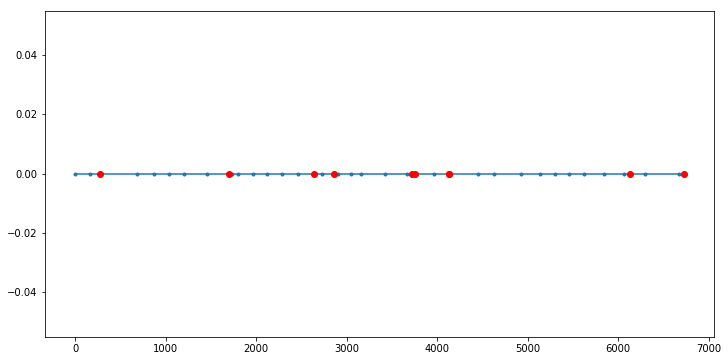

In [63]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(cum_dist, [0]*len(cum_dist), '.-')
ax.plot(df['VehDistAlongRoute'], [0]*len(df), 'ro')
plt.show()

## 3b. Plain Topology

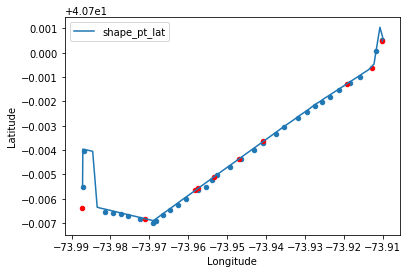

In [64]:
# plot route
ax = temp_shp.plot('shape_pt_lon', 'shape_pt_lat')

# plot stops
B54_stops.plot.scatter('stop_lon', 'stop_lat', ax=ax)

# plot active buses
df.plot.scatter('Longitude', 'Latitude', color='red', ax=ax)

## 3c. Map Topology

In [ ]:
import gmap

## 3d. Time-space Diagram
Also include a log file!

## 4. Simulation
## 4a. Objects Creation

## 4b. Attribute Assignment

## 4c. Environment Variables

## 4d. User Interface

## 4e. Dynamic Display
1. 0.5-sec update
2. time-space diagram
3. trace log

## 4f. Web Deployment
1. Control panel
2. Real-time info on Google basemap
3. Real-time info on straightened route topology
    - 3a. BB indicator
4. Dynamic time-space diagram

# End

- 3/11 4
- 3/12 1.5
- 3/16 1
- 3/17 2
- 3/18 2
- 3/20 1.5

In [60]:
#trips[(trips['service_id'] == "FP_D7-Weekday-SDon") & (trips['route_id'] == "B54") & (trips['direction_id'] == direction)]

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
53306,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-006700_B54_201,RIDGEWOOD TERM via MYRTLE,0,B540062
53307,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-013200_B54_201,RIDGEWOOD TERM via MYRTLE,0,B540062
53308,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-019700_B54_201,RIDGEWOOD TERM via MYRTLE,0,B540062
53309,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-026200_B54_201,RIDGEWOOD TERM via MYRTLE,0,B540062
53310,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-029600_B54_202,RIDGEWOOD TERM via MYRTLE,0,B540062
53311,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-032600_B54_204,RIDGEWOOD TERM via MYRTLE,0,B540062
53312,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-035600_B54_206,RIDGEWOOD TERM via MYRTLE,0,B540062
53313,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-038500_B54_202,RIDGEWOOD TERM via MYRTLE,0,B540062
53314,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-040500_B54_207,RIDGEWOOD TERM via MYRTLE,0,B540062
53315,B54,FP_D7-Weekday-SDon,FP_D7-Weekday-SDon-043500_B52_110,RIDGEWOOD TERM via MYRTLE,0,B540062


In your addPassenger method, you need to make sure you haven't reached your "capacity". If you have, raise an exception. Also ensure the parameter is type checked and only allows Passenger objects.

This doesn't really have anything to do with python, it's merely a simple problem that requires you to demonstrate some python knowledge. Realistically, this can be solved in any language.

In [ ]:
class Bus:
    # Properties
    lineref = "B54"
    origin = "Where I came from"
    detinsation = "Where I am going"

    __capacity = Max Passengers
    __passengers = {} # Key on the passenger name

    # Methods
    addPassenger(passenger)
    removePassenger(passengerName)

class Passenger:
    # Properties
    name = "Foo"
    route = "Not set"

In [2]:
# import pygame
# import math
# import random
 
# # globals for user interface
# WIDTH = 800
# HEIGHT = 600
# score = 0
# lives = 3
# time = 0.5
# started = False
 
# class ImageInfo:
 
#     def __init__(self, center, size, radius=0, lifespan=None, animated=False):
#         self.center = center
#         self.size = size
#         self.radius = radius
#         if lifespan:
#             self.lifespan = lifespan
#         else:
#             self.lifespan = float('inf')
#         self.animated = animated
 
#     def get_center(self):
#         return self.center
 
#     def get_size(self):
#         return self.size
 
#     def get_radius(self):
#         return self.radius
 
#     def get_lifespan(self):
#         return self.lifespan
 
#     def get_animated(self):
#         return self.animated
 
 
# # debris images - debris1_brown.png, debris2_brown.png, debris3_brown.png, debris4_brown.png
# # debris1_blue.png, debris2_blue.png, debris3_blue.png, debris4_blue.png,
# # debris_blend.png
# debris_info = ImageInfo([320, 240], [640, 480])
# debris_image = simplegui.load_image(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/lathrop/debris2_blue.png")
 
# # nebula images - nebula_brown.png, nebula_blue.png
# nebula_info = ImageInfo([400, 300], [800, 600])
# nebula_image = simplegui.load_image(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/lathrop/nebula_blue.f2013.png")
 
# # splash image
# splash_info = ImageInfo([200, 150], [400, 300])
# splash_image = simplegui.load_image(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/lathrop/splash.png")
 
# # ship image
# ship_info = ImageInfo([45, 45], [90, 90], 35)
# ship_image = simplegui.load_image(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/lathrop/double_ship.png")
 
# # missile image - shot1.png, shot2.png, shot3.png
# missile_info = ImageInfo([5, 5], [10, 10], 3, 50)
# missile_image = simplegui.load_image(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/lathrop/shot2.png")
 
# # asteroid images - asteroid_blue.png, asteroid_brown.png, asteroid_blend.png
# asteroid_info = ImageInfo([45, 45], [90, 90], 40)
# asteroid_image = simplegui.load_image(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/lathrop/asteroid_blue.png")
 
# # animated explosion - explosion_orange.png, explosion_blue.png,
# # explosion_blue2.png, explosion_alpha.png
# explosion_info = ImageInfo([64, 64], [128, 128], 17, 24, True)
# explosion_image = simplegui.load_image(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/lathrop/explosion_alpha.png")
 
# # sound assets purchased from sounddogs.com, please do not redistribute
# # .ogg versions of sounds are also available, just replace .mp3 by .ogg
# soundtrack = simplegui.load_sound(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/sounddogs/soundtrack.mp3")
# missile_sound = simplegui.load_sound(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/sounddogs/missile.mp3")
# missile_sound.set_volume(.5)
# ship_thrust_sound = simplegui.load_sound(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/sounddogs/thrust.mp3")
# explosion_sound = simplegui.load_sound(
#     "http://commondatastorage.googleapis.com/codeskulptor-assets/sounddogs/explosion.mp3")
 
 
# # helper functions to handle transformations
# def angle_to_vector(ang):
#     return [math.cos(ang), math.sin(ang)]
 
# def dist(p, q):
#     return math.sqrt((p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2)

# def process_sprite_group(group, canvas):
#     for each in set(group):
#         each.draw(canvas)
#         if each.update():
#             group.remove(each)

# def group_collide(group, other_object):
#     global explosion_group
#     collided = False
#     for each in set(group):
#         if each.collide(other_object):
#             group.remove(each)
#             collided = True
#             explosion_group.add(Sprite(each.pos, [0, 0], 0, 0, explosion_image,
#                                        explosion_info, explosion_sound))
#     return collided
 
# def group_group_collide(group, other_group):
#     counter = 0
#     for each in set(group):
#         collision = group_collide(other_group, each)
#         if collision:
#             group.remove(each)
#             counter += 1
#     return counter
 
 
# # Ship class
# class Ship:
 
#     def __init__(self, pos, vel, angle, image, info):
#         self.pos = [pos[0], pos[1]]
#         self.vel = [vel[0], vel[1]]
#         self.thrust = False
#         self.angle = angle
#         self.angle_vel = 0
#         self.image = image
#         self.image_center = info.get_center()
#         self.image_size = info.get_size()
#         self.radius = info.get_radius()
 
#     def draw(self, canvas):
#         center = list(self.image_center)
#         if self.thrust:
#             center[0] = self.image_center[0] + self.image_size[0]
#         canvas.draw_image(self.image, center, self.image_size,
#                           self.pos, self.image_size, self.angle)
 
#     def update(self):
#         # angle
#         self.angle += self.angle_vel
 
#         # position
#         self.pos[0] = (self.pos[0] + self.vel[0]) % WIDTH
#         self.pos[1] = (self.pos[1] + self.vel[1]) % HEIGHT
 
#         # velocity
#         if self.thrust:
#             acc = angle_to_vector(self.angle)
#             self.vel[0] += acc[0] * .1
#             self.vel[1] += acc[1] * .1
 
#         self.vel[0] *= .99
#         self.vel[1] *= .99
 
#     def set_thrust(self, on):
#         self.thrust = on
#         if on:
#             ship_thrust_sound.rewind()
#             ship_thrust_sound.play()
#         else:
#             ship_thrust_sound.pause()
 
#     def increment_angle_vel(self):
#         self.angle_vel += .05
 
#     def decrement_angle_vel(self):
#         self.angle_vel -= .05
 
#     def shoot(self):
#         global missile_group
#         forward = angle_to_vector(self.angle)
#         missile_pos = [self.pos[0] + self.radius * forward[0],
#                        self.pos[1] + self.radius * forward[1]]
#         missile_vel = [self.vel[0] + 6 * forward[0],
#                        self.vel[1] + 6 * forward[1]]
#         missile_group.add(Sprite(missile_pos, missile_vel, self.angle, 0,
#                                  missile_image, missile_info, missile_sound))
 
 
# # Sprite class
# class Sprite:
 
#     def __init__(self, pos, vel, ang, ang_vel, image, info, sound=None):
#         self.pos = [pos[0], pos[1]]
#         self.vel = [vel[0], vel[1]]
#         self.init_vel = [vel[0], vel[1]]
#         self.angle = ang
#         self.angle_vel = ang_vel
#         self.image = image
#         self.image_center = info.get_center()
#         self.image_size = info.get_size()
#         self.radius = info.get_radius()
#         self.lifespan = info.get_lifespan()
#         self.animated = info.get_animated()
#         self.age = 0
#         if sound:
#             sound.rewind()
#             sound.play()
 
#     def draw(self, canvas):
#         center = list(self.image_center)
#         if self.animated:
#             center[0] = self.image_center[0] + (self.image_size[0] * self.age)
#         canvas.draw_image(self.image, center, self.image_size,
#                           self.pos, self.image_size, self.angle)
 
#     def update(self):
#         # angle
#         self.angle += self.angle_vel
 
#         # position
#         self.pos[0] = (self.pos[0] + self.vel[0]) % WIDTH
#         self.pos[1] = (self.pos[1] + self.vel[1]) % HEIGHT
 
#         self.age += 1
#         return self.age > self.lifespan
 
#     def collide(self, other_object):
#         return dist(self.pos, other_object.pos) <= self.radius + other_object.radius
 
 
# # key handlers to control ship
# def keydown(key):
#     if key == simplegui.KEY_MAP['left']:
#         my_ship.decrement_angle_vel()
#     elif key == simplegui.KEY_MAP['right']:
#         my_ship.increment_angle_vel()
#     elif key == simplegui.KEY_MAP['up']:
#         my_ship.set_thrust(True)
#     elif key == simplegui.KEY_MAP['space']:
#         my_ship.shoot()

# def keyup(key):
#     if key == simplegui.KEY_MAP['left']:
#         my_ship.increment_angle_vel()
#     elif key == simplegui.KEY_MAP['right']:
#         my_ship.decrement_angle_vel()
#     elif key == simplegui.KEY_MAP['up']:
#         my_ship.set_thrust(False)
 
 
# # mouseclick handlers that reset UI and conditions whether splash image is
# # drawn
# def click(pos):
#     global started, lives, score, soundtrack
#     center = [WIDTH / 2, HEIGHT / 2]
#     size = splash_info.get_size()
#     inwidth = (center[0] - size[0] / 2) < pos[0] < (center[0] + size[0] / 2)
#     inheight = (center[1] - size[1] / 2) < pos[1] < (center[1] + size[1] / 2)
#     if (not started) and inwidth and inheight:
#         started = True
#         lives = 3
#         score = 0
#         soundtrack.rewind()
#         soundtrack.play()
 
 
# def draw(canvas):
#     global time, started, score, lives, rock_group, my_ships
 
#     # animiate background
#     time += 1
#     center = debris_info.get_center()
#     size = debris_info.get_size()
#     wtime = (time / 8) % center[0]
#     canvas.draw_image(nebula_image, nebula_info.get_center(),
#                       nebula_info.get_size(), [WIDTH / 2, HEIGHT / 2],
#                       [WIDTH, HEIGHT])
#     canvas.draw_image(debris_image, [center[0] - wtime, center[1]],
#                       [size[0] - 2 * wtime, size[1]],
#                       [WIDTH / 2 + 1.25 * wtime, HEIGHT / 2],
#                       [WIDTH - 2.5 * wtime, HEIGHT])
#     canvas.draw_image(debris_image, [size[0] - wtime, center[1]],
#                       [2 * wtime, size[1]], [1.25 * wtime, HEIGHT / 2],
#                       [2.5 * wtime, HEIGHT])
 
#     # increase rock's velocity using score
#     for rock in rock_group:
#         for i in range(2):
#             rock.vel[i] = rock.init_vel[i] + (rock.init_vel[i] * score * 0.03)
 
#     # draw ship and sprites
#     my_ship.draw(canvas)
#     my_ship.update()
#     process_sprite_group(rock_group, canvas)
#     process_sprite_group(missile_group, canvas)
#     process_sprite_group(explosion_group, canvas)
 
#     # process collisions
#     if group_collide(rock_group, my_ship):
#         lives -= 1
#     score += group_group_collide(missile_group, rock_group) * 10
 
#     # check game status
#     if lives == 0:
#         rock_group = set()
#         started = False
 
#     # draw UI
#     canvas.draw_text("Lives", [50, 60], 30, "white")
#     canvas.draw_text(str(lives), [50, 90], 30, "white")
#     canvas.draw_text("Score", [690, 60], 30, "white")
#     canvas.draw_text(str(score), [690, 90], 30, "white")
 
#     # draw splash screen if not started
#     if not started:
#         canvas.draw_image(splash_image, splash_info.get_center(),
#                           splash_info.get_size(), [WIDTH / 2, HEIGHT / 2],
#                           splash_info.get_size())
 
 
# # timer handler that spawns a rock
# def rock_spawner():
#     global rock_group, started
#     if len(rock_group) > 12 or not started:
#         return
#     rock_vel = [random.random() * .6 - .3, random.random() * .6 - .3]
#     rock_avel = random.random() * .2 - .1
#     rock_pos = [random.randrange(0, WIDTH), random.randrange(0, HEIGHT)]
#     # ensure rock_pos is at least 100px away of my_ship
#     while dist(rock_pos, my_ship.pos) < 100:
#         rock_pos = [random.randrange(0, WIDTH), random.randrange(0, HEIGHT)]
#     # add rock to the group
#     rock_group.add(Sprite(rock_pos, rock_vel, 0, rock_avel,
#                           asteroid_image, asteroid_info))
 
 
# # initialize stuff
# frame = simplegui.create_frame("Asteroids", WIDTH, HEIGHT)
 
# # initialize ship and two sprites
# my_ship = Ship([WIDTH / 2, HEIGHT / 2], [0, 0], 0, ship_image, ship_info)
# rock_group = set()
# missile_group = set()
# explosion_group = set()
 
 
# # register handlers
# frame.set_keyup_handler(keyup)
# frame.set_keydown_handler(keydown)
# frame.set_mouseclick_handler(click)
# frame.set_draw_handler(draw)
 
# timer = simplegui.create_timer(1000.0, rock_spawner)
 
# # get things rolling
# timer.start()
# frame.start()

NameError: name 'simplegui' is not defined

In [ ]:
# Author: Yuwen Chang, NYU CUPS, September 2017
##############################
# Code written for HW2 of PUI2017
# https://github.com/ywnch/PUI2017_ywc249/HW2_ywc249
##############################
# put MTA API key and bus route as input arguments:
# i.e. run the code as:
# 	python show_bus_locations_ywc249.py <MTA_KEY> <BUS_LINE>
##############################

# # ensure compatibility and allow reading line input args
# from __future__ import print_function
# import sys

# # check input args
# if not len(sys.argv) == 3:
#     print ("Invalid number of arguments. Run as: python show_bus_locations_ywc249.py <MTA_KEY> <BUS_LINE>")
#     sys.exit()

# # import packages
# try:
#     import urllib2 as urllib
# except ImportError:
#     import urllib.request as urllib

# import os
# import json

# # read args and generate url to fetch data from
# apikey = sys.argv[1]
# bus = sys.argv[2]
# url = "http://bustime.mta.info/api/siri/vehicle-monitoring.json?key=%s&VehicleMonitoringDetailLevel=calls&LineRef=%s"%(apikey, bus)
# #print("API URL: \n" + url)

In [ ]:
# # Author: Yuwen Chang, NYU CUPS, September 2017
# ##############################
# # Code written for HW2 of PUI2017
# # https://github.com/ywnch/PUI2017_ywc249/HW2_ywc249
# ##############################
# # put MTA API key, bus route, and output csv file as input arguments:
# # i.e. run the code as:
# # 	python get_bus_info_ywc249.py <MTA_KEY> <BUS_LINE> <BUS_LINE>.csv
# ##############################

# # ensure compatibility and allow reading line input args
# from __future__ import print_function
# import sys

# # check input args
# if not len(sys.argv) == 4:
#     print ("Invalid number of arguments. Run as: python get_bus_info_ywc249.py <MTA_KEY> <BUS_LINE> <BUS_LINE>.csv")
#     sys.exit()

# # import packages
# try:
#     import urllib2 as urllib
# except ImportError:
#     import urllib.request as urllib

# import os
# import json
# import pandas as pd

# # read args and generate url to fetch data from
# apikey = sys.argv[1]
# bus = sys.argv[2]
# file = sys.argv[3]
# url = "http://bustime.mta.info/api/siri/vehicle-monitoring.json?key=%s&VehicleMonitoringDetailLevel=calls&LineRef=%s"%(apikey, bus)
# #print("API URL: \n" + url)

# # fetch data
# response = urllib.urlopen(url)
# data = response.read().decode("utf-8")
# data = json.loads(data)

# # check if bus route exists
# try:
#     data2 = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['VehicleActivity']
# except:
#     error = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['ErrorCondition']
#     print(error['Description'])
#     sys.exit()

# # parse info
# lat = []
# lng = []
# stop = []
# status = []

# for v in data2:
#     #global lat, lng, stop, status

#     # parse location
#     lt = v['MonitoredVehicleJourney']['VehicleLocation']['Latitude']
#     lg = v['MonitoredVehicleJourney']['VehicleLocation']['Longitude']
#     lat.append(lt)
#     lng.append(lg)

#     # parse next stop info
#     if 'OnwardCall' in v['MonitoredVehicleJourney']['OnwardCalls']:
#         s = v['MonitoredVehicleJourney']['OnwardCalls']['OnwardCall'][0]
#         stt = s['Extensions']['Distances']['PresentableDistance']
#         stp = s['StopPointName']
#     else:
#         stt = 'N/A'
#         stp = 'N/A'
#     status.append(stt)
#     stop.append(stp)

# # write data to dictionary, indexing from 1
# d = {'Latitude': lat, 'Longitude': lng, 'Stop Name': stop, 'Stop Status': status}
# df = pd.DataFrame(data = d)
# df.index += 1

# # write df to csv file
# with open('%s'%(file), 'w') as f:
#     df.to_csv('%s'%(file))